<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [CS4740 Labs] Week 6: Deep Generative Models

##Introduction

One of the big successes of Deep Learning that sparked significant interest in the last few years is Deep Generative Models. These are deep neural architectures whose main goal is *analysis-by-synthesis*. In other words, they represent an attempt to analyse a complex dataset by synthesizing new datapoints that preserve the statistical properties of the original data. In achieving this, the deep generative models are able to extract meaningful information about the statistical distribution that gave rise to the original dataset, thereby providing us with some sort of *high-level understanding*. 

These Deep Generative architectures have been used to generate realistic data from a variety of sources, including among others, celebrity face images and artistic paintings!

In this lab we will explore some of the properties of Deep Generative Models by running several experiments using simple versions of popular generative architectures. 

##A very simple VAE

Let's begin by exploring a very simple toy dimensionality reduction problem. To keep things easy to visualize, we will limit ourselves to two dimensions. The code below generates the well known spiral dataset. 

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np

def spiral(n_points, noise=1.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    dx = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    dy = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return np.hstack((dx,dy))

Let's see what this looks like:

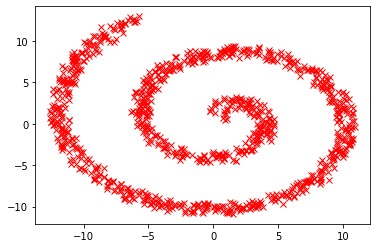

In [3]:
X = spiral(n_points=1000)
plt.plot(X[:,0],X[:,1],'rx')

What we immediately observe is that while the points are two-dimensional, the space they come from is only one-dimensional. Which means this dataset could be a good candidate for a Variational Auto-Encoder with a 1-dimensional encoding. We will be using the simple MLP class below for both encoder and decoder networks. The network layers are generated according to the input of the constructor. The `hidden` holds the sizes of all the hidden layers (if any). We also define the input and output sizes.

In [4]:
class MLPNet(nn.Module):
    def __init__(self, input_size=2, hidden=[3], output_size=2):
        super(MLPNet, self).__init__()
        s0=input_size
        self.hidden_layers = nn.ModuleList()
        for h in hidden:
            self.hidden_layers.append(nn.Sequential(nn.Linear(s0,h),nn.LeakyReLU()))
            s0=h
        self.classifier= nn.Linear(s0,output_size)
        
    def forward(self, x):
        for f in self.hidden_layers:
            x = f(x)
        return self.classifier(x)

Let us experiment with an encoder network that takes maps two dimentional input to one dimensional output:


In [5]:
enc = MLPNet(input_size=2, hidden=[64,256,512,128], output_size=1)
X = spiral(n_points=1000)
x = torch.tensor(X,dtype=torch.float)

z = enc(x)
print(x.shape)
print(z.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


The decoder network will similarly map the 1D code back onto the 2D space of the original data:


In [6]:
dec = MLPNet(input_size=1, hidden=[64,256,512,128], output_size=2)

x_=dec(z)
print(z.shape)
print(x_.shape)

torch.Size([1000, 1])
torch.Size([1000, 2])


We are now ready to define the training code for encoder and decoder networks. The loss function we use is MSE because the autoencoder must reproduce its own input as closely as possible. The loss we compute has this form:

`L = loss(x, dec(enc(x)))`

which penalises the difference between the input datapoint and the reconstructed version of that datapoint as it passes through the bottleneck of the autoencoder. 

Every 1000 epochs we will produce a scatterplot of the reconstructed input data superimposed on the original data. If all goes well we should observe an overlap between the two. 

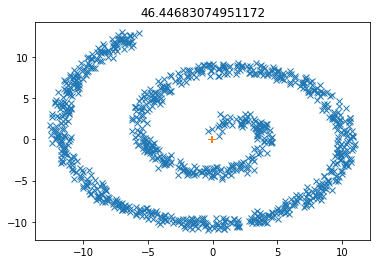

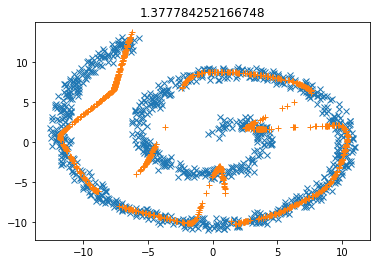

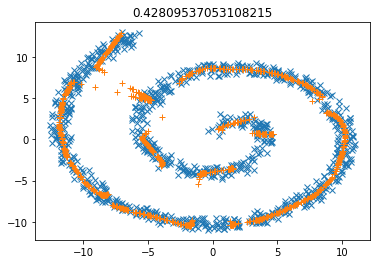

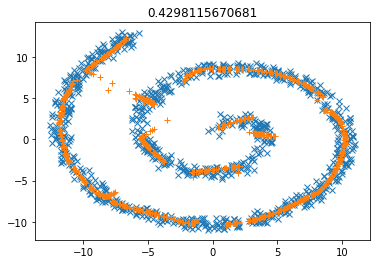

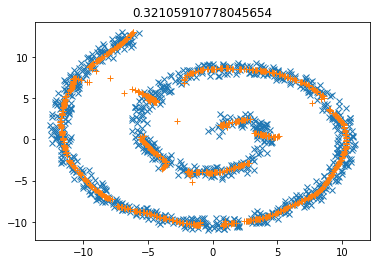

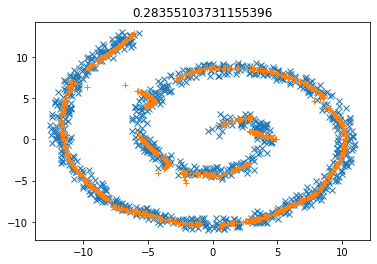

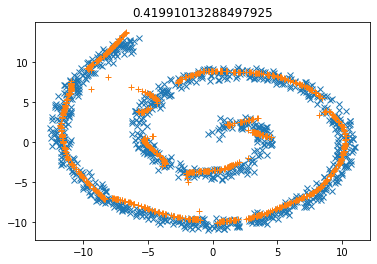

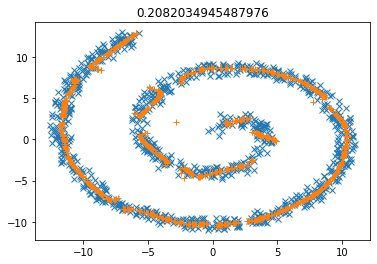

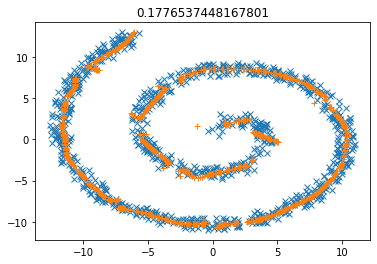

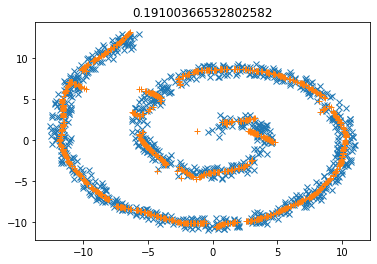

In [7]:
from itertools import chain

N = 1000
X = spiral(n_points=N)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(X,dtype=torch.float, device=device)
num_of_epochs = 10000
z_dim = 1

enc = MLPNet(input_size=2, hidden=[128,256,128], output_size=z_dim).to(device)
dec = MLPNet(input_size=z_dim, hidden=[128,256,128], output_size=2).to(device)

optimizer = optim.Adam(chain(enc.parameters(),dec.parameters()), lr=0.001)

loss = nn.MSELoss(reduction='mean')

for e in range(num_of_epochs):
    # z = enc(x)
    # # z += 1e-2*torch.randn_like(z, device=device)
    # x_ = dec(z)
    # # L = loss(x, x_) + 1e-4*z.square().sum()
    # # L = loss(x, x_)
    L = loss(x, dec(enc(x)))
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    if e%1000 ==0:
        x_ = dec(enc(x))
        x_ = x_.cpu().detach().numpy()
        plt.figure()
        plt.plot(X[:,0],X[:,1],'x')
        plt.plot(x_[:,0],x_[:,1],'+')
        plt.title(f"{L.item()}")
        plt.show()
    

The auto-encoder seems able to reproduce the input with a very simple architecture.

## A very simple GAN

Before we move to more realistic applications, let us try a very simple (perhaps the most simple) GAN solution to the same spiral dataset problem. Similar to the auto-encoder, the GAN approach also uses two networks, a generator and a discriminator. In fact the generator can be identical to the decoder network of the auto-encoder in terms of input/output dimensionality. The discriminator is slightly different to the encoder network in that its output is a binary classification probability instead of an encoding. 

Given a datapoint $x$ and some randomly generated code $z$, we would like to optimize the following function with thespect to the parameters of discriminator $D$ and generator $G$:

$$
V(D,G)=\log D(x)+\log(1-D(G(z)))
$$

The minimax formulation of this loss function 

In [8]:
N = 1000

X = spiral(n_points=N)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(X,dtype=torch.float, device=device)
num_of_epochs = 50000
z_dim = 2

disc = MLPNet(input_size=2, hidden=[128,256,128], output_size=1).to(device)
gen = MLPNet(input_size=z_dim, hidden=[128,256,128], output_size=2).to(device)

optim_d = optim.Adam(disc.parameters(), lr=0.001)
optim_g = optim.Adam(gen.parameters(), lr=0.001)

loss = nn.BCEWithLogitsLoss()

zeros = torch.zeros(N,1,device=device)
ones = torch.ones(N,1,device=device)

for e in range(num_of_epochs):
    z = torch.randn(N,z_dim, device=device)

    L_dis = loss(disc(gen(z)),zeros) + loss(disc(x), ones)
    optim_d.zero_grad()
    L_dis.backward()
    optim_d.step()

    L_gen = loss(disc(gen(z)),ones)
    optim_g.zero_grad()
    L_gen.backward()
    optim_g.step()

    if e%1000 ==0:
        x_gen = gen(z).cpu().detach().numpy()
        plt.figure()
        plt.plot(X[:,0],X[:,1],'x')
        plt.plot(x_gen[:,0],x_gen[:,1],'+')
        plt.show()

KeyboardInterrupt: ignored

Try with one-dimensional $z$.